First import the essen

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
#renders figure inline
%matplotlib inline 

Load and inspect data

In [131]:
#give full path to zip folder and .csv (works for multiple files in foldeR)
zip_path = r'C:\Users\Sonia Singh\Downloads\health_data_1.zip'

with zipfile.ZipFile(zip_path) as z:
    print(z.namelist()) #see all files in zip
    with z.open('KaggleV2-May-2016.csv') as f: #needs exact .csv name)
        df = pd.read_csv(f)

['KaggleV2-May-2016.csv']


Explore data basic check

In [54]:
df.head()
#df.info()
#df.describe()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Prep data

In [132]:
#rename cols
df.columns = (
    df.columns
        .str.lower()
        .str.replace('_','')
                    )

In [133]:
#handle missing data
df.columns
df.isnull().sum()
df.dropna(subset=['age'], inplace = True)

In [134]:
#convert dates
df.columns
df['appointmentday']=pd.to_datetime(df['appointmentday'])
df['scheduledday']=pd.to_datetime(df['scheduledday'])

In [135]:
#add new cols
df.columns

#'.dt.days' --- only works on timedelta columns (like datetime1 - datetime2)
df['lead_days']=(df['appointmentday']-df['scheduledday']).dt.days

#'.dt.day_name()' --- only works on datetime columns, returns the weekday string
df['appointment_weekday']=df['appointmentday'].dt.day_name()

In [136]:
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,smsreceived,no-show,lead_days,appointment_weekday
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1,Friday
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1,Friday
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1,Friday
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1,Friday
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1,Friday


Explore & aggregate data

In [137]:
#Filtering
adults = df[df['age'] > 18]

In [138]:
#no-show rate by neighborhood
#no_show_rate = df.groupby('neighbourhood')['no-show'].apply(lambda x: (x=='Yes').mean())
#no_show_rate.sort_values(ascending=False).head(5)

no_show_rate = (
    df.assign(no_show_flag = df['no-show'] == 'Yes') #created a boolean/ flag column
    .groupby('neighbourhood')['no_show_flag']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

In [139]:
#Group by weekday and caluclate no-show rate
weekday_no_show = (
    df.assign(no_show_flag = df['no-show']=='Yes')
    .groupby('appointment_weekday')['no_show_flag']
    .mean()
    .sort_values(ascending=False)
)
weekday_no_show
    

appointment_weekday
Saturday     0.230769
Friday       0.212261
Monday       0.206471
Tuesday      0.200936
Wednesday    0.196892
Thursday     0.193541
Name: no_show_flag, dtype: float64

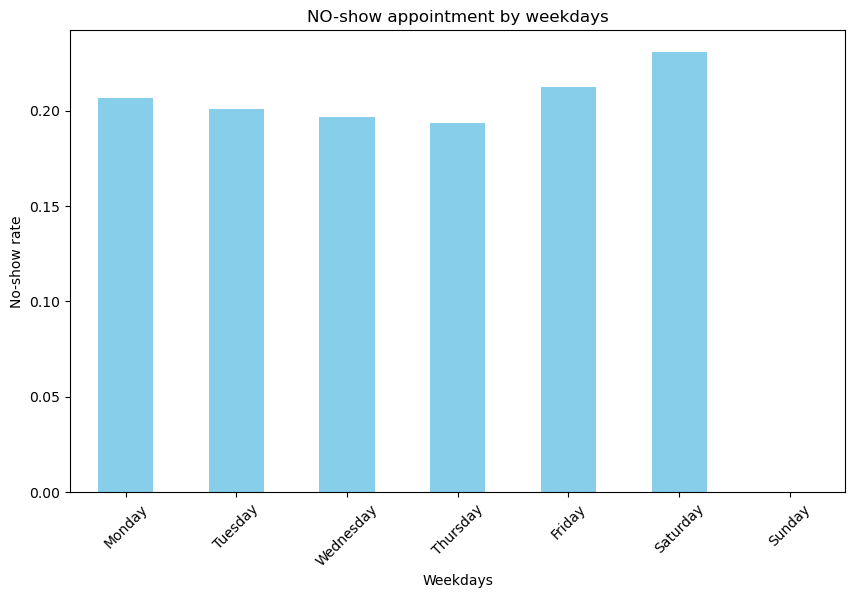

In [174]:
#To plot - order the weekdays
weekday_order = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
weekday_no_show = weekday_no_show.reindex(weekday_order)

plt.figure()
weekday_no_show.plot(kind='bar', figsize=(10,6), color='skyblue')
plt.xlabel("Weekdays")
plt.ylabel("No-show rate")
plt.title("NO-show appointment by weekdays")
plt.xticks(rotation=45)
plt.show()

In [140]:
#Do longer lead times affect no-show rate?
        ## group by lead time and calculate no-show rate
lead_time_no_show = (
    df.assign(no_show_flag = df['no-show']=='Yes')
              .groupby('lead_days')['no_show_flag']
              .mean()
              .sort_values(ascending=False).head(20).round(2)
             )
lead_time_no_show


lead_days
-7      1.00
 131    1.00
 150    1.00
 145    1.00
 125    1.00
-2      1.00
 138    1.00
 103    0.75
 154    0.60
 102    0.60
 109    0.50
 54     0.45
 79     0.44
 59     0.42
 88     0.41
 39     0.41
 24     0.40
 80     0.40
 77     0.39
 78     0.39
Name: no_show_flag, dtype: float64

In [141]:
# since I keep using the 'no_show_flag' --- create column
df['no_show_flag'] = df['no-show']=='Yes'

In [158]:
#use groupby with multiple columns
no_show_neigh = (
    df.groupby(['neighbourhood','appointment_weekday'])['no_show_flag']
    .mean()
    .reset_index()
    .sort_values(by='no_show_flag', ascending=False).head(10).round(2)
)
no_show_neigh

,neighbourhood,appointment_weekday,no_show_flag
171,ILHAS OCEÂNICAS DE TRINDADE,Friday,1.00
162,ILHA DO FRADE,Friday,0.50
143,HORTO,Monday,0.41
389,UNIVERSITÁRIO,Friday,0.36
303,SANTA CLARA,Friday,0.35
393,UNIVERSITÁRIO,Wednesday,0.34
344,SANTOS DUMONT,Friday,0.33
263,PONTAL DE CAMBURI,Friday,0.33
340,SANTO ANTÔNIO,Saturday,0.33
2,AEROPORTO,Thursday,0.33


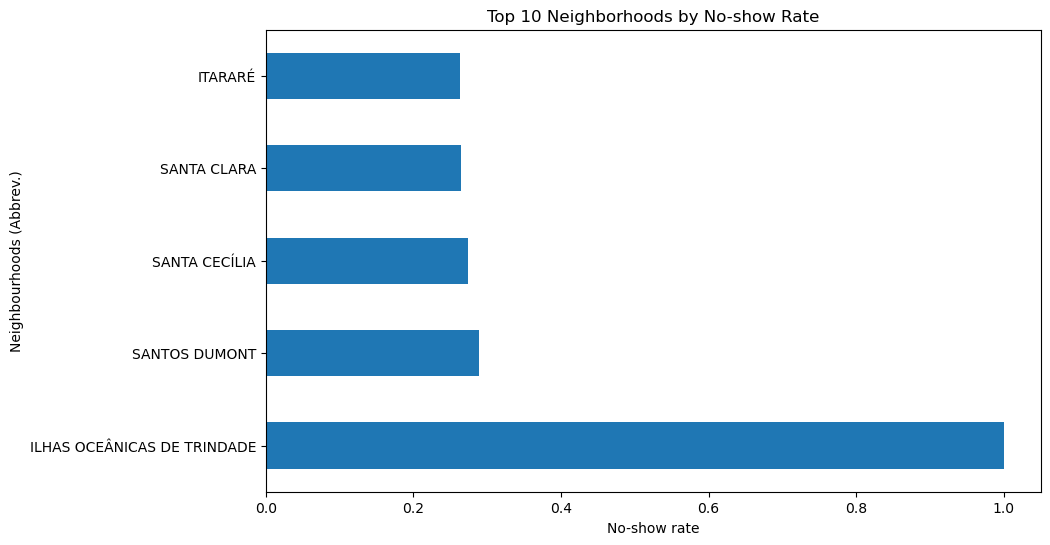

In [167]:
#plot rtates by neighbourhood
plt.figure() 
# plot
no_show_rate.plot(kind='barh', figsize=(10,6))

# replace y-axis tick labels with first 3 letters
#plt.yticks(ticks=range(len(no_show_rate)), labels=[name[:3] for name in no_show_rate.index])

plt.xlabel("No-show rate")
plt.ylabel("Neighbourhoods (Abbrev.)")
plt.title("Top 10 Neighborhoods by No-show Rate")
plt.show()

In [143]:
#horizontal over vertical tabulation
pivot_no_show = pd.pivot_table(
    df,
    values='no_show_flag',
    index='neighbourhood',
    columns='appointment_weekday',
    aggfunc='mean'
).round(2)

pivot_no_show

appointment_weekday,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
neighbourhood,,,,,,
AEROPORTO,0.00,0.00,NaN,0.33,0.00,NaN
ANDORINHAS,0.22,0.23,NaN,0.24,0.23,0.24
ANTÔNIO HONÓRIO,0.26,0.19,NaN,0.11,0.25,0.13
ARIOVALDO FAVALESSA,0.22,0.28,0.0,0.20,0.23,0.19
BARRO VERMELHO,0.20,0.20,NaN,0.27,0.18,0.26
...,...,...,...,...,...,...
SÃO JOSÉ,0.23,0.22,NaN,0.20,0.21,0.22
SÃO PEDRO,0.25,0.25,NaN,0.17,0.22,0.16
TABUAZEIRO,0.17,0.20,NaN,0.16,0.19,0.18


In [144]:
#Flag values above a threshold (e.g., > 0.3 or 30%) -- looks better with highlights
high_no_show_flag = pivot_no_show.where(pivot_no_show > 0.3, other=False)
high_no_show_flag

appointment_weekday,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
neighbourhood,,,,,,
AEROPORTO,False,False,False,0.33,False,False
ANDORINHAS,False,False,False,False,False,False
ANTÔNIO HONÓRIO,False,False,False,False,False,False
ARIOVALDO FAVALESSA,False,False,False,False,False,False
BARRO VERMELHO,False,False,False,False,False,False
...,...,...,...,...,...,...
SÃO JOSÉ,False,False,False,False,False,False
SÃO PEDRO,False,False,False,False,False,False
TABUAZEIRO,False,False,False,False,False,False


In [145]:
#Flag values above a threshold (e.g., > 0.3 or 30%) -- looks nicer
pivot_no_show.style.map(lambda x: 'background-color: yellow' if x > 0.3 else '')

appointment_weekday,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
neighbourhood,,,,,,
AEROPORTO,0.000000,0.000000,nan,0.330000,0.000000,nan
ANDORINHAS,0.220000,0.230000,nan,0.240000,0.230000,0.240000
ANTÔNIO HONÓRIO,0.260000,0.190000,nan,0.110000,0.250000,0.130000
ARIOVALDO FAVALESSA,0.220000,0.280000,0.000000,0.200000,0.230000,0.190000
BARRO VERMELHO,0.200000,0.200000,nan,0.270000,0.180000,0.260000
BELA VISTA,0.210000,0.200000,nan,0.220000,0.160000,0.240000
BENTO FERREIRA,0.250000,0.220000,nan,0.250000,0.240000,0.180000
BOA VISTA,0.170000,0.220000,nan,0.260000,0.170000,0.120000
BONFIM,0.200000,0.180000,nan,0.190000,0.190000,0.230000


No-show rates by time of day

In [146]:
#extract the times from the correct columns
## appointmentday time is always midnight so not helpful
df['scheduled_hour']=df['scheduledday'].dt.hour
df[['scheduled_hour']].head(10)

In [150]:
#get mean no-show rates by sheduled hour
no_show_by_sched_hour = (
    df.groupby('scheduled_hour', as_index=False)['no_show_flag']
        .mean()
        .round(2)
)
no_show_by_sched_hour

,scheduled_hour,no_show_flag
0,6,0.19
1,7,0.15
2,8,0.18
3,9,0.20
4,10,0.22
5,11,0.23
6,12,0.20
7,13,0.21
8,14,0.23
9,15,0.23


<Axes: >